In [2]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
# from modplot import *
def make_qp(nk,fname="qp.temp",nk_start=0,nk_stop=1):
    try:
        os.remove(fname)
    except:
        None
    kx=ky=np.linspace(nk_start,nk_stop,nk)
    cnt=0
    for i in kx:
        for j in ky:
            print("{:.3f} {:.3f} 0.00".format(i,j),file=open(fname, "a"))
            cnt+=1
    print("nkp = {}".format(cnt))
    
def get_s(fname='bnds.temp'):
    with open(fname) as f:
        lines = f.readlines()
    def extract_nums(text):
           return [float(i)for i in re.findall("[+-]?\d+\.\d+", text)]
    def chunks(l, n):
        n = max(1, n)
        return (l[i:i+n] for i in range(0, len(l), n))
    sx=[]
    sy=[]
    sz=[]
    e=[]
    for i in chunks(lines[1:],6):
        try:
            e.append(extract_nums(i[-5]))
            sx.append(extract_nums(i[-3]))
            sy.append(extract_nums(i[-2]))
            sz.append(extract_nums(i[-1]))
        except: None
    sx=np.array(sx)
    sy=np.array(sy)
    sz=np.array(sz)
    e=np.array(e)
    n=int(np.sqrt(sz.shape[0]))
    sx=sx.T.reshape(-1,n,n)
    sy=sy.T.reshape(-1,n,n)
    sz=sz.T.reshape(-1,n,n)
    e=e.T.reshape(-1,n,n)
    return sx,sy,sz,e


def interp(e,nk=201):
    from scipy.interpolate import interp2d
    kx2 = np.linspace(0, 1, nk)
    ky2 = np.linspace(0, 1, nk)
    f = interp2d(kx, ky, e, kind='cubic')
    e_interp = f(kx2, ky2)
    return e_interp



def get_ef(fname="bnds.temp"):
    with open(fname) as f:
        lines = f.readlines()
    return float(lines[0].split("=")[-2].split()[0])

In [39]:
nk=30
make_qp(nk,nk_start=-0.3,nk_stop=0.3)

nkp = 900


 mpirun -np 16 lmf --band\~colst\~qp\~lst=21,22,23,24\~mq ctrl.temp

In [43]:
# fname="bands_data/bnds_full_new.temp"
fname="bands_data/bnds_gamma_new.temp"
# fname="bnds_data/bnds_full.temp"
ef=get_ef(fname)
sx,sy,sz,e=get_s(fname)
e=e-ef

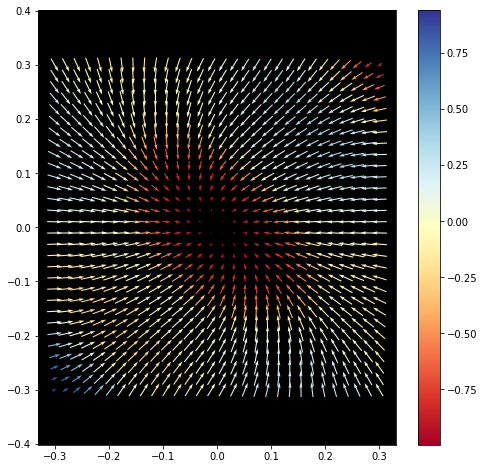

In [7]:
nk=30
kx=ky=np.linspace(-0.3,0.3,nk)
i=0
fig,ax=plt.subplots(figsize=(8,8))
ax.set_facecolor("k")
plt.axis('equal')

plt.quiver(kx, ky, sx[i], sy[i],sz[i], scale=35,width=.002, units='xy',cmap="RdYlBu",pivot="middle")
plt.colorbar()
# plt.ylim([-.05,.4])
# plt.xlim([-.05,.4])
plt.show()

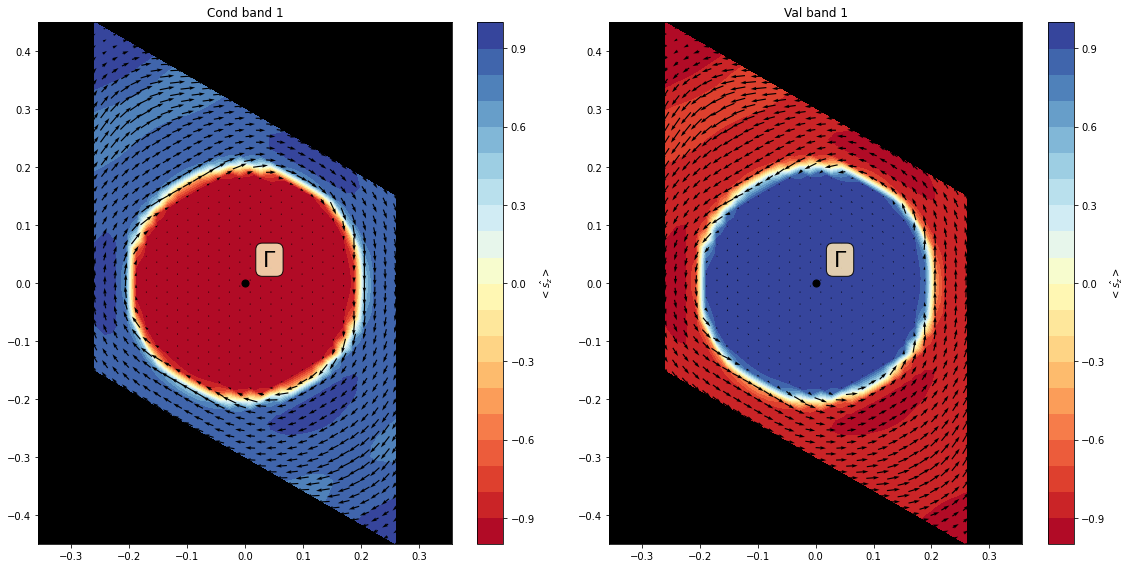

In [52]:
def plot_spins(ax,nbnd=1):
    sq3o2=np.sqrt(3.)/2.
    nk=30
    erange=[-0.3,0.3]
    k0=np.linspace(erange[0],erange[1],nk)
    kx=np.zeros((nk,nk),dtype=float)
    ky=np.zeros((nk,nk),dtype=float)
    for i in range(nk):
        for j in range(nk):
            kx[i,j]=sq3o2*k0[i]
            ky[i,j]=-0.5*k0[i]-k0[j]
    i=nbnd

    ax.set_facecolor("k")
    ax.axis('equal')
    # plt.quiver(kx, ky, sx[i], sy[i],sz[i], scale=8,width=.01, units='xy',cmap="RdYlBu",pivot="middle")
    ax.quiver(kx, ky, sx[i], sy[i], scale=25,width=2e-3, units='xy',color="k",pivot="middle")
    r=ax.contourf(kx,ky,sz[i],20,zorder=-1,cmap="RdYlBu")
    fig.colorbar(r, ax=ax, orientation='vertical',label="$<\hat{s_z}>$")


fig,ax1=plt.subplots(1,2,figsize=(16,8))
ax=ax1[0]
plot_spins(ax,nbnd=0)
ax.set_title("Cond band 1")
ax=ax1[1]
plot_spins(ax,nbnd=1)
ax.set_title("Val band 1")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
for i in ax1:
    i.text(0.03,0.03,"$\\Gamma$",fontsize=22,bbox=props)
    i.scatter(0,0,s=50,c="k")
plt.tight_layout()
# plt.savefig("Spin-texture.png",dpi=200)
plt.show()

ValueError: Invalid inputs.

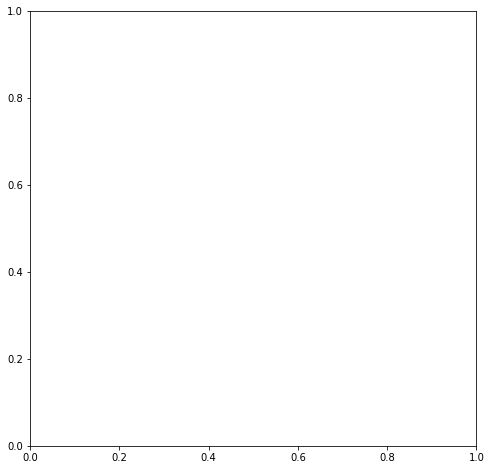

In [56]:
from skimage import measure
sq3o2=np.sqrt(3.)/2.


fig,ax=plt.subplots(figsize=(8,8))

NK=200

sq3o2=np.sqrt(3.)/2.
nk=30
erange=[-0.3,0.3]
kx=np.zeros((nk,nk),dtype=float)
ky=np.zeros((nk,nk),dtype=float)

E=interp(e[0],nk=100)
e_cont=np.unique(np.sort(E.flatten()))[-1*NK]
contours = measure.find_contours(E, e_cont)
for n, contour in enumerate(contours):
    x=contour[:, 0]*sq3o2
    y=+0.5*contour[:, 0]*sq3o2+contour[:, 1]
    ax.plot(x,y, linewidth=1,c="green")  
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=1,c="k")
    
    
E=interp(e[1],nk=100)
e_cont=np.unique(np.sort(E.flatten()))[-1*NK]
contours = measure.find_contours(E, e_cont)
for n, contour in enumerate(contours):
    x=contour[:, 0]*sq3o2
    y=+0.5*contour[:, 0]*sq3o2+contour[:, 1]
    ax.plot(x,y, linewidth=1,c="r",ls="--")    
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=1,c="r")    



points=((np.array([[0,0],[0,1],[np.cos(np.pi/6),np.sin(np.pi/6)+1],[np.cos(np.pi/6),np.sin(np.pi/6)],[0,0]])-0.5)*1.04+0.5)*E.shape[0]
ax.plot(points.T[0],points.T[1]-5,c="k",lw=2,ls="-.")


ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

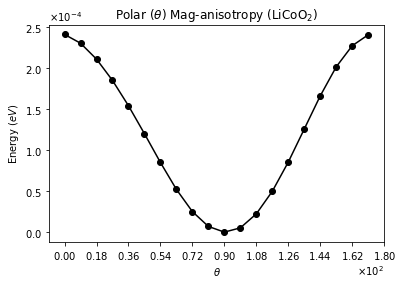

In [69]:
data=np.loadtxt("bands_data/anisotropy_theta.dat")
data=data[:-1]
data.T[1]-=data.T[1].min()
fig,ax=plt.subplots()
ax.plot(np.rad2deg(data.T[0]),data.T[1],marker="o",c="k")
ax.ticklabel_format(style="sci",useMathText=True,scilimits=(5,1))
ax.set_ylabel("Energy ($eV$)");ax.set_xlabel(r"$\theta$")
ax.set_xticks(np.linspace(0,180,11))
ax.set_title("Polar ($\\theta$) Mag-anisotropy (LiCoO$_2$)")
plt.savefig("Mag-polar-ani.png",dpi=200)
plt.show()

In [317]:
data=np.loadtxt("bands_data/anisotropy.dat")

[20 20] [ 7 27]


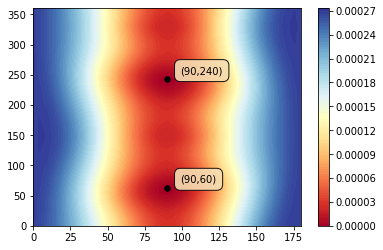

In [318]:
theta=data.T[0];phi=data.T[1];e=data.T[2]-data.T[2].min()


fig,ax=plt.subplots()


theta=np.rad2deg(np.linspace(theta.min(),theta.max(),41))
phi=np.rad2deg(np.linspace(phi.min(),phi.max(),41))
r=ax.contourf(theta,phi,e.reshape(41,41).T,90,cmap="RdYlBu")



x,y=np.where(e.reshape(41,41)==e.min())
print(x,y)
for i,j in zip(x,y):
    ax.scatter(theta[i],phi[j],s=30,c="k")
    props = dict(boxstyle='round,pad=0.6', facecolor='wheat', alpha=0.9)
    ax.text(theta[i]+9,phi[j]+9,"({:.0f},{:.0f})".format(theta[i],phi[j]-3),c="k",size=10,bbox=props)
plt.colorbar(r)
plt.show()

In [353]:
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode(connected=True)


u, v = np.mgrid[0:np.pi:41j, 0:2*np.pi:41j]

x = 10 * np.sin(u) * np.cos(v)
y = 10 * np.sin(u) * np.sin(v)
z = 10 * np.cos(u)

trace= go.Surface(z=z, x=x, y=y,surfacecolor=e.reshape(41,41),colorscale="rdylbu_r",cmin=e.min(),cmax=e.max()*0.3,opacity=1)
data=[trace]

points=np.array([[[0,0,0],[0,0,1]],
                 [[0,0,0],[0,1,0]],
                 [[0,0,0],[1,0,0]],
#                  [[0,0,0],[0,0,-1]],
#                  [[0,0,0],[0,-1,0]],
#                  [[0,0,0],[-1,0,0]],
                 
                ])*15
for i in points:
    data.append(go.Scatter3d(
    x=i.T[0], y=i.T[1], z=i.T[2],
    marker=dict(
        size=9,
        color=z,
        colorscale='Viridis',
        symbol='diamond',
    ),
    line=dict(
        color='darkblue',
        width=5,
        dash="dash"
    )
))

    
x1,y1=np.where(e.reshape(41,41)==e.min())
for i,j in zip(x1,y1):
    u=np.deg2rad(theta[i]);v=np.deg2rad(phi[j])
    d=1.1
    x = 10 * np.sin(u) * np.cos(v) * d
    y = 10 * np.sin(u) * np.sin(v) * d
    z = 10 * np.cos(u) * d
    data.append(go.Scatter3d(
    x=[x], y=[y], z=[z],
    marker=dict(
        size=9,
        color="black",
        symbol='circle',
    ),
    line=dict(
        color='darkblue',
        width=0,
        
    )
))
    
    
layout=go.Layout(showlegend=False)

fig=go.Figure(data=data, layout=layout)

# d=15
# fig.update_layout(
#     scene = dict(
#         xaxis = dict(showgrid=False,range=[-d,d]),
#         yaxis = dict(showgrid=False,range=[-d,d]),
#         zaxis = dict(showgrid=False,range=[-d,d]),
#     ),
# )


py.iplot(fig)

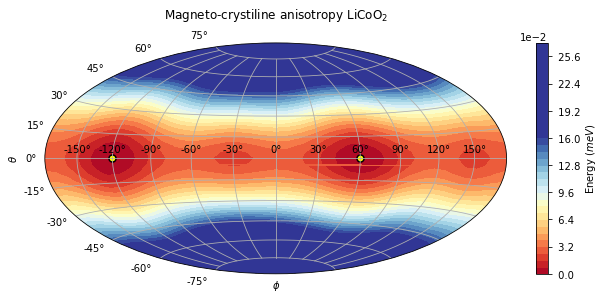

In [452]:
import matplotlib.ticker
from matplotlib import pyplot as plt
import numpy as np


class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="% 1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
             self.format = r'$\mathdefault{%s}$' % self.format



fig = plt.figure(figsize=(9,4))
ax=plt.subplot(111, projection="hammer")
theta=np.linspace(-np.pi,np.pi,41)
phi=np.linspace(-np.pi/2,np.pi/2,41)
r=ax.contourf(theta,phi,e.reshape(41,41)*1e3,40,cmap="RdYlBu",vmax=e.max()*0.6*1e3)
plt.colorbar(r,label="Energy ($meV$)", format=OOMFormatter(-2, mathText=False))
x,y=np.where(e.reshape(41,41)==e.min())
ax.set_title("Magneto-crystiline anisotropy LiCoO$_2$", y=1.08)
for i,j in zip(y,x):
    ax.scatter(theta[i]-np.deg2rad(3),phi[j],s=50,c="yellow",edgecolors='k',linewidth=1.5)
plt.grid()
ax.set_ylabel("$\\theta$")
ax.set_xlabel("$\\phi$")
plt.tight_layout()
plt.savefig("Mag_ani-full.png",dpi=210)
plt.show()